In [1]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="Tennis_Linux_NoVis/Tennis.x86_64")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)
# size of each action
# actions between -1 and 1
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)
# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [2]:
# main function that sets up environments
# perform training loop

from buffer import ReplayBuffer
from maddpg import MADDPG
import torch
import numpy as np
from tensorboardX import SummaryWriter
import os
from utilities import transpose_list, transpose_to_tensor
from collections import deque

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# for saving gif
import imageio

def seeding(seed=1):
    np.random.seed(seed)
    torch.manual_seed(seed)

def pre_process(entity, batchsize):
    processed_entity = []
    for j in range(3):
        list = []
        for i in range(batchsize):
            b = entity[i][j]
            list.append(b)
        c = torch.Tensor(list)
        processed_entity.append(c)
    return processed_entity


seeding()

# number of parallel agents
# parallel_envs = 4

# number of training episodes.
# change this to higher number to experiment. say 30000.
number_of_episodes = 3000
episode_length = 1000
batchsize = 128
# how many episodes to save policy and gif
save_interval = 1000
t = 0

scores_deque = deque(maxlen=100)
scores = []

# amplitude of OU noise
# this slowly decreases to 0
noise = 2
noise_reduction = 0.9999

# how many episodes before update
episode_per_update = 2

log_path = os.getcwd()+"/log"
model_dir= os.getcwd()+"/model_dir"

os.makedirs(model_dir, exist_ok=True)

# torch.set_num_threads(parallel_envs)
# env = envs.make_parallel_env(parallel_envs)

# keep 5000 episodes worth of replay
buffer = ReplayBuffer(500000,batchsize,0)

# initialize policy and critic
maddpg = MADDPG(seed=100)
logger = SummaryWriter(log_dir=log_path)
agent0_reward = []
agent1_reward = []

# training loop
# show progressbar
import progressbar as pb
widget = ['episode: ', pb.Counter(),'/',str(number_of_episodes),' ', 
          pb.Percentage(), ' ', pb.ETA(), ' ', pb.Bar(marker=pb.RotatingMarker()), ' ' ]

timer = pb.ProgressBar(widgets=widget, maxval=number_of_episodes).start()

best_score = 0
max_score = 0

# use keep_awake to keep workspace from disconnecting
for episode in range(0, number_of_episodes):

    timer.update(episode)

    for agent in maddpg.maddpg_agent:
        agent.noise.reset()

    reward_this_episode = np.zeros(2)
    env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
    state = env_info.vector_observations # get the current state (for each agent)

    #for calculating rewards for this particular episode - addition of all time steps

    # save info or not
    save_info = ((episode % save_interval) < episode==number_of_episodes)
    frames = []
    tmax = 0

#     if save_info:
#         frames.append(env.render('rgb_array'))

    r0 = 0
    r1 = 0
    for episode_t in range(episode_length):

        t += 1


        # explore = only explore for a certain number of episodes
        # action input needs to be transposed
        actions = maddpg.act(torch.tensor(state,dtype=torch.float).to(device), noise=noise)
        noise *= noise_reduction

        action = torch.stack(actions).detach().numpy()

        # step forward one frame
        # next_obs, next_obs_full, rewards, dones, info = env.step(actions_for_env)
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations
        reward = env_info.rewards
        done = env_info.local_done
        
        cat_state = np.concatenate((state[0],state[1]))
        cat_next_state = np.concatenate((next_state[0],next_state[1]))
        
        # add data to buffer
        #transition = (obs, obs_full, actions_for_env, rewards, next_obs, next_obs_full, dones)
        transition = (state, cat_state, action, reward, next_state, cat_next_state, done)
        
        buffer.add(*transition)

        r0 += reward[0]
        r1 += reward[1]
        state = next_state
        
        # save gif frame
        if episode % 100 == 0 :
#             frames.append(env.render('rgb_array'))
            tmax+=1
        #if any of the agents are done break   
        if len(buffer) > batchsize and episode % episode_per_update == 0:
            for a_i in range(2):
                samples = buffer.sample()
                maddpg.update(samples, a_i, logger)
            maddpg.update_targets() #soft update the target network towards the actual networks
        
        if np.any(done):            
            break            
    # update once after every episode_per_update

    agent0_reward.append(r0)
    agent1_reward.append(r1)
    r = max(r0,r1)
    
    scores.append(r)
    scores_deque.append(r)
    
    if episode % 100 == 0:
        avg_rewards = [np.mean(agent0_reward), np.mean(agent1_reward)]
        agent0_reward = []
        agent1_reward = []
        for a_i, avg_rew in enumerate(avg_rewards):
            logger.add_scalar('agent%i/mean_episode_rewards' % a_i, avg_rewards[a_i], episode)
#             print("agent %d /mean_episode_rewards %2f episode %d",a_i,avg_rewards[a_i],episode)
        print("mean_episode_rewards {:.4f} episode {}".format(np.mean(scores_deque),episode))            

        #saving model
        save_dict_list =[]
        if best_score < np.mean(scores_deque):
            for i in range(2):

                save_dict = {'actor_params' : maddpg.maddpg_agent[i].actor.state_dict(),
                             'actor_optim_params': maddpg.maddpg_agent[i].actor_optimizer.state_dict(),
                             'critic_params' : maddpg.maddpg_agent[i].critic.state_dict(),
                             'critic_optim_params' : maddpg.maddpg_agent[i].critic_optimizer.state_dict()}
                save_dict_list.append(save_dict)

                torch.save(save_dict_list, 
                           os.path.join(model_dir, 'episode-{}.pt'.format(episode)))

            # save gif files
            imageio.mimsave(os.path.join(model_dir, 'episode-{}.gif'.format(episode)), 
                            frames, duration=.04)
            best_score = np.mean(scores_deque)

env.close()
logger.close()
timer.finish()

episode: 2/3000   0% ETA:   0:03:13 |-                                       | 

mean_episode_rewards 0.0000 episode 0


episode: 99/3000   3% ETA:   0:07:33 |/                                      | 

mean_episode_rewards 0.0037 episode 100


episode: 201/3000   6% ETA:   0:09:16 |-                                     | 

mean_episode_rewards 0.0310 episode 200


episode: 301/3000  10% ETA:   0:09:22 |/                                     | 

mean_episode_rewards 0.0280 episode 300


episode: 401/3000  13% ETA:   0:09:29 ||                                     | 

mean_episode_rewards 0.0460 episode 400


episode: 501/3000  16% ETA:   0:09:21 |\                                     | 

mean_episode_rewards 0.0450 episode 500


episode: 601/3000  20% ETA:   0:09:04 |-                                     | 

mean_episode_rewards 0.0360 episode 600


episode: 701/3000  23% ETA:   0:08:53 |-                                     | 

mean_episode_rewards 0.0440 episode 700


episode: 801/3000  26% ETA:   0:08:39 |/                                     | 

mean_episode_rewards 0.0480 episode 800


episode: 901/3000  30% ETA:   0:08:32 |-                                     | 

mean_episode_rewards 0.0510 episode 900


episode: 1001/3000  33% ETA:   0:08:10 ||                                    | 

mean_episode_rewards 0.0403 episode 1000


episode: 1101/3000  36% ETA:   0:08:07 |/                                    | 

mean_episode_rewards 0.0693 episode 1100


episode: 1201/3000  40% ETA:   0:08:08 |-                                    | 

mean_episode_rewards 0.0979 episode 1200


episode: 1301/3000  43% ETA:   0:08:35 |\                                    | 

mean_episode_rewards 0.2097 episode 1300


episode: 1401/3000  46% ETA:   0:12:53 |\                                    | 

mean_episode_rewards 0.8383 episode 1400


episode: 1501/3000  50% ETA:   0:16:30 ||                                    | 

mean_episode_rewards 0.7591 episode 1500


episode: 1602/3000  53% ETA:   0:17:08 |\                                    | 

mean_episode_rewards 0.4301 episode 1600


episode: 1701/3000  56% ETA:   0:20:45 |-                                    | 

mean_episode_rewards 1.1486 episode 1700


episode: 1801/3000  60% ETA:   0:23:30 |-                                    | 

mean_episode_rewards 1.1596 episode 1800


episode: 1902/3000  63% ETA:   0:23:15 |-                                    | 

mean_episode_rewards 0.7937 episode 1900


episode: 2002/3000  66% ETA:   0:23:53 |\                                    | 

mean_episode_rewards 1.0498 episode 2000


episode: 2101/3000  70% ETA:   0:24:12 |/                                    | 

mean_episode_rewards 1.0916 episode 2100


episode: 2201/3000  73% ETA:   0:25:33 |/                                    | 

mean_episode_rewards 1.6799 episode 2200


episode: 2301/3000  76% ETA:   0:25:17 |/                                    | 

mean_episode_rewards 1.5299 episode 2300


episode: 2401/3000  80% ETA:   0:24:27 |\                                    | 

mean_episode_rewards 1.7619 episode 2400


episode: 2501/3000  83% ETA:   0:22:28 ||                                    | 

mean_episode_rewards 1.7658 episode 2500


episode: 2601/3000  86% ETA:   0:18:03 |\                                    | 

mean_episode_rewards 0.6297 episode 2600


episode: 2701/3000  90% ETA:   0:14:06 |-                                    | 

mean_episode_rewards 1.1352 episode 2700


episode: 2801/3000  93% ETA:   0:09:30 ||                                    | 

mean_episode_rewards 0.7458 episode 2800


episode: 2901/3000  96% ETA:   0:04:53 |-                                    | 

mean_episode_rewards 1.0032 episode 2900


episode: 3000/3000 100% Time:  2:28:35 ||                                    | 


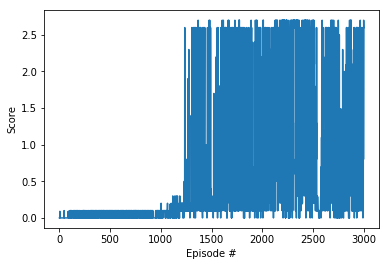

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()